# AI Stock Predictor

## Roadmap
1. Download and filter historic data of a stock (or multiple stocks)
2. Standardize stock values for our AI model
3. Split up dataset of stock values into training and testing datasets
4. Set up AI model
5. Train and test AI model
6. Fetch and filter latest history of stock
7. Predict recent Close value with AI and compare it to the real Close value
8. Improve our AI model with experimentation

Install **YFinance**, **pandas**, and **pytorch** (for local users, not Colab)

`pip install -U yfinance pandas --no-cache-dir`

`pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124`

## 0. Setup preliminary resources

In [1]:
import yfinance as yf
import pandas as pd
import torch
from sklearn.model_selection import KFold

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We want to make an AI model that can predict future Market Close values based on the stock's past values. We can retrieve a stock's history from a certain timeframe (3 months ago).

Add a ticker tracking a stock
 
*Ticker = set of letters (e.g., MSFT for microsoft) identifying a stock, providing relevant stock history like market value

We will use NVIDIA (NVDA), a semiconductor company known for making GPUs, for this example

## 1. Download & filter data of a stock

In [3]:
nvda = yf.Ticker("NVDA") 

In [4]:
raw_df = nvda.history(period="3mo").astype(float) # ensure consistency

In [5]:
raw_df.isnull().values.any() # no null values, so we dont have to worry about removing them

False

In [6]:
raw_df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-16 00:00:00-04:00,133.970762,136.610579,131.570934,135.710648,264879700.0,0.0,0.0
2024-10-17 00:00:00-04:00,139.330400,140.880297,136.860569,136.920563,306435900.0,0.0,0.0
2024-10-18 00:00:00-04:00,138.660446,138.890426,137.270542,137.990494,176090200.0,0.0,0.0
2024-10-21 00:00:00-04:00,138.120486,143.700104,137.990491,143.700104,264554500.0,0.0,0.0
2024-10-22 00:00:00-04:00,142.900163,144.410053,141.770236,143.580109,226311600.0,0.0,0.0


We want our AI model to predict what the Close values will be. To do this, we must categorize this historic data into two sections: training and testing data.


Training Data (**Features**): Open, High, Low, Volume (They seem to have significant value)

Testing Data (**Labels**): Close 

In [7]:
raw_df = raw_df.drop(columns=["Dividends", "Stock Splits"])

In [8]:
features_df = raw_df.drop("Close", axis=1) # features is everything except Close column, notice how we use axis=1 to select column since it will try to look in rows
label_df = raw_df.pop("Close") # this will be its own column
label_df = label_df.rename("Close")

In [9]:
features_df.shape, label_df.shape

((62, 4), (62,))

## 2. Standardize stock values for our AI model

To make sure our AI model does not worry too much on the numbers in our dataset, we will **standardize** our (training) data to ensure it only focuses on the patterns. We will use a StandardScaler from Scikit-Learn which adjusts every number to have a total mean of zero and standard deviation of one.

Note that we do not normalize for our case, as normalizing limits the prediction capabilities of our model to its recorded highest and lowest stock prices (we cannot predict out of these numbers). We will also be using a loss function called Mean Square Error which will change our error scale to the value of the NVIDIA stock, rendering us unable to measure the accuracy and loss of our model.

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
feature_standardizer = StandardScaler()
norm_df = feature_standardizer.fit_transform(features_df, y=label_df) # apply normalization to make a numpy array
features_df = pd.DataFrame(norm_df, index=features_df.index, columns=features_df.columns) # convert the normalized array to a dataframe once again

label_standardizer = StandardScaler()
norm_df = label_standardizer.fit_transform(label_df.to_frame()) # MinMaxScaler requires this
label_df = pd.DataFrame(norm_df, index=label_df.index, columns=["Close"]) # extra touch to rename it Close

In [12]:
features_df.head(5)

,Open,High,Low,Volume
Date,,,,
2024-10-16 00:00:00-04:00,-1.165007,-1.094465,-1.171935,0.902057
2024-10-17 00:00:00-04:00,-0.129408,-0.226643,-0.090329,1.653811
2024-10-18 00:00:00-04:00,-0.258858,-0.631085,-0.006500,-0.704152
2024-10-21 00:00:00-04:00,-0.363190,0.346484,0.140713,0.896174
2024-10-22 00:00:00-04:00,0.560348,0.490782,0.913582,0.204357


In [13]:
label_df.head(5)

,Close
Date,
2024-10-16 00:00:00-04:00,-0.787653
2024-10-17 00:00:00-04:00,-0.541841
2024-10-18 00:00:00-04:00,-0.324469
2024-10-21 00:00:00-04:00,0.835523
2024-10-22 00:00:00-04:00,0.811144


In [14]:
features_df.shape, label_df.shape

((62, 4), (62, 1))

## 3. Split up dataset of stock values into training and testing datasets

We will separate our features and labels into training and testing data with the help of Scikit-Learn's TimeSeriesSplit function.

Unlike Scikit-Learn's train_test_split function, TimeSeriesSplit works like folding a paper with small folds, keeping time-crucial events adjacent to each other when training/testing (though, it will be fairly random in batches of sequential time periods). Until the TimeSeriesSplit reaches the desired number of folds, it will assign all other folds except the last fold made to training, while the last fold is saved for testing. Our stock data is like the piece of paper, so we will divide our dataset into the default 5 divisions.

TimeSeriesSplit will slowly add more information for the AI model to train on with more folds to introduce the rest of the dataset.

To be more specific, any previously made folds will have training data, while the last/new fold will have testing data. If we have 5 folds in our entire stock dataset, we will have 4 folds dedicated to training, while having only 1 fold (at the end of the dataset) for our testing data.

tl;dr Training Dataset: 4/5 (80%) of data, Testing Dataset: 1/5 (20%) of data

This is what it should look like when you choose to split your information

Note how this split offers indices of where to cut the dataset, so parts of the dataset are slowly introduced to the AI model for training.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

Let's simulate what our folds will look like as we train and test our model. Each number represents a sample, or row, of the stock information we will train our model on. Notice how the train_index (training dataset) gets bigger at each new fold (index). If we look closely, we can see that each new fold adds the test dataset to the training dataset and introduces a newer training dataset.

In [16]:
special_split = TimeSeriesSplit(n_splits=5) # default is 5 but will be useful to change later

for index, (train_index, test_index) in enumerate(special_split.split(features_df)): # we get special train/test indexes for our dataset to use
        print(f"index: {index}, train_index: {train_index}, test_index: {test_index}")
        X_train, X_test = features_df.iloc[train_index, :], features_df.iloc[test_index, :] # update X_train/X_test by inserting the usual values into the custom indexes
        y_train, y_test = label_df.iloc[train_index], label_df.iloc[test_index] # same as above but for y_train/y_test

index: 0, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11], test_index: [12 13 14 15 16 17 18 19 20 21]
index: 1, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21], test_index: [22 23 24 25 26 27 28 29 30 31]
index: 2, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31], test_index: [32 33 34 35 36 37 38 39 40 41]
index: 3, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41], test_index: [42 43 44 45 46 47 48 49 50 51]
index: 4, train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51], test_index: [52 53 54 55 56 57 58 59 60 61]


Lets go through how the AI model will interpret these variables full of information.

The X related variables are for the AI model to train with, while the y related variabels are for its testing phase.

- **X_train**: This is the information with columns like "Open" and "High" where the AI model will analyze patterns in the numbers.
- **y_train**: This is the list of "Close" values respective to each row from X_train. The AI model will find a way to correlate how the stock values calculate to the Close values.

- **X_test**: This is a dataset full of "Open," "High," "Low," and "Volume," data where the AI model is only allowed to analyze and not learn from. It will use this dataset to predict its "Close" answer, but will be checked for how accurate it is later.
- **y_test**: These are the answers to what the "Close" answers should be for the X_test dataset. We will compare these real "Close" values to the AI model's "Close" predictions, and determine how accurate it is when predicting from a 3 month history of a stock.

In [17]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (52, 4), X_test: (10, 4), y_train: (52, 1), y_test: (10, 1)


## 4. Set up AI model

We will be making an AI model that resembles thinking like our brains. This is a special part of AI called deep-learning, which imitates the function of human brains. Unlike our brains that must have its neurons activated repeatedly to learn, our AI model learns from our cost function, or a formula that determines how wrong it is on each prediction it makes during training. To learn, it will adjust a bunch of numbers that make up its neurons and (hopefully) minimize the cost (that is, make the cost function say there is less error for every new prediction) by the end of training.  

(GO OVER AFTER MAKING MODEL)
Look at how our in_features and out_features for the first and last Linear layers are not the same numbers as the layers in between. This is because we are changing the AI model to fit our needs by accepting the data that we want it to accept. In an easier explanation, we are creating an AI model that can accept the stock information we will give it.

In [18]:
from torch.nn import Sequential, Linear, ReLU, Dropout

In [19]:
model = Sequential(
    Linear(in_features=X_train.shape[1], out_features=64, dtype=torch.float),  # 4 columns for in_features from whichever train dataset (in this case X_train.shape[1] as its a tuple)
    ReLU(),
    Dropout(0.2),
    Linear(in_features=64, out_features=64, dtype=torch.float),
    ReLU(),
    Dropout(0.2),
    Linear(in_features=64, out_features=1, dtype=torch.float)
).to(device)  # use GPU for faster training if possible
model

# best so far: 
# Sequential(
#   (0): Linear(in_features=4, out_features=64, bias=True)
#   (1): ReLU()
#   (2): Dropout(p=0.2, inplace=False)
#   (3): Linear(in_features=64, out_features=64, bias=True)
#   (4): ReLU()
#   (5): Linear(in_features=64, out_features=128, bias=True)
#   (6): ReLU()
#   (7): Linear(in_features=128, out_features=64, bias=True)
#   (8): ReLU()
#   (9): Dropout(p=0.2, inplace=False)
#   (10): Linear(in_features=64, out_features=1, bias=True)
# )

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

### 4.1 Setup loss and optimizers

Loss functions and optimizers are very important to how AI models learn, as they correct the AI model from making future mistakes with every time it learns. Both of these are really just code that deal with lots of numbers, but they help the model in ways that you might not expect. The loss function tells the model how bad it tries to guess while it trains its learning, while the optimizer is responsible for telling the model how to improve.

In [20]:
from torch.nn import MSELoss

In [21]:
loss_fn = MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1) # best so far: 0.001

In [22]:
# pandas dataframe -> raw values -> pytorch tensor

def df_to_pytensor(dataset: pd.DataFrame, device, dtype=torch.float) -> torch.Tensor:
    """Converts a Pandas Dataframe to a Pytorch Tensor (for training/testing loops)"""
    return torch.tensor(dataset.values, dtype=dtype, device=device)

# needed to avoid bias between each fold
def reset_weights(model: Sequential):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

In [23]:
splits = 5

epoch_per_fold = 20 # best so far: 100

epochs = splits * epoch_per_fold

# epochs = how many times the ai model will go through the entire X_train/y_train dataset
print(f"Epochs: {epochs}\neach split/fold will run {epoch_per_fold} epochs")

Epochs: 100
each split/fold will run 20 epochs


## 5. Train and test AI model

In [24]:
#x_train & y_train go together
#x_test and y_test go together
special_split = TimeSeriesSplit(n_splits=5) # default is 5 but will be useful to change later

results = {}

for fold, (train_index, test_index) in enumerate(special_split.split(features_df)): # we get special train/test indexes for our dataset to use 
    X_train, X_test = features_df.iloc[train_index, :], features_df.iloc[test_index, :] # update X_train/X_test by inserting the usual values into the custom indexes
    y_train, y_test = label_df.iloc[train_index], label_df.iloc[test_index] # same as above but for y_train/y_test
    
    X_train = df_to_pytensor(X_train, device)
    X_test = df_to_pytensor(X_test, device)
    y_train = df_to_pytensor(y_train, device)
    y_test = df_to_pytensor(y_test, device)
    
    reset_weights(model)
    
    print(f"FOLD {fold}")
    print("-----------------------------")
    for epoch in range(1, epochs+1):
        model.train()  # set to train mode
        
        y_pred = model(X_train) # make prediction on dataset
        
        loss = loss_fn(y_pred, y_train) # tell computer how bad it guessed compared to real answer
        
        optimizer.zero_grad() # make ai model reflect and improve itself for the next epoch
        loss.backward() # back propagation (remind itself what it did wrong last time)
        
        optimizer.step() # improvement can take a pause until the next time it fails
            
        if epoch % 100 == 0: # every 20 epochs
            print(f"Epoch: {epoch} | Loss: {loss:.2%}")
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    print(f"Test Loss: {test_loss:.2%}")
    results[fold] = test_loss
    
    #torch.save(model.state_dict(), f"./model-fold-{fold}.pth")
    

FOLD 0
-----------------------------
Epoch: 100 | Loss: 6.38%
Test Loss: 36.74%
FOLD 1
-----------------------------
Epoch: 100 | Loss: 23.61%
Test Loss: 15.75%
FOLD 2
-----------------------------
Epoch: 100 | Loss: 10.23%
Test Loss: 11.49%
FOLD 3
-----------------------------
Epoch: 100 | Loss: 4.97%
Test Loss: 14.53%
FOLD 4
-----------------------------
Epoch: 100 | Loss: 11.04%
Test Loss: 11.56%


In [25]:
print(f"FOLD RESULTS")
print("-----------------------------")

for key, value in results.items():
    print(f"Fold {key} Loss: {value:.2%}")

print(f"Average Loss: {sum(results.values())/len(results.items()):.2%}")

FOLD RESULTS
-----------------------------
Fold 0 Loss: 36.74%
Fold 1 Loss: 15.75%
Fold 2 Loss: 11.49%
Fold 3 Loss: 14.53%
Fold 4 Loss: 11.56%
Average Loss: 18.01%


In [26]:
# see how wrong the model is on testing dataset
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    
print(f"Test Loss: {test_loss:.2%}")

Test Loss: 11.56%


In [27]:
# make a prediction with the model on the testing dataset for visualization later
y_test_pred = model(X_test)

In [28]:
# everything is on gpu, so put to cpu since standardizer is also on it
X_test = feature_standardizer.inverse_transform(X_test.cpu())
y_test = label_standardizer.inverse_transform(y_test.cpu())

# detaching prevents the model from learning if we decide to mess with the prediction's values
y_test_pred = label_standardizer.inverse_transform(y_test_pred.cpu().detach().numpy())

Let's visualize how our model predicts by looking at our stock's value compared to what our model is predicting. This is the test dataset that our model was learning on.

In [33]:
from matplotlib import pyplot as plt

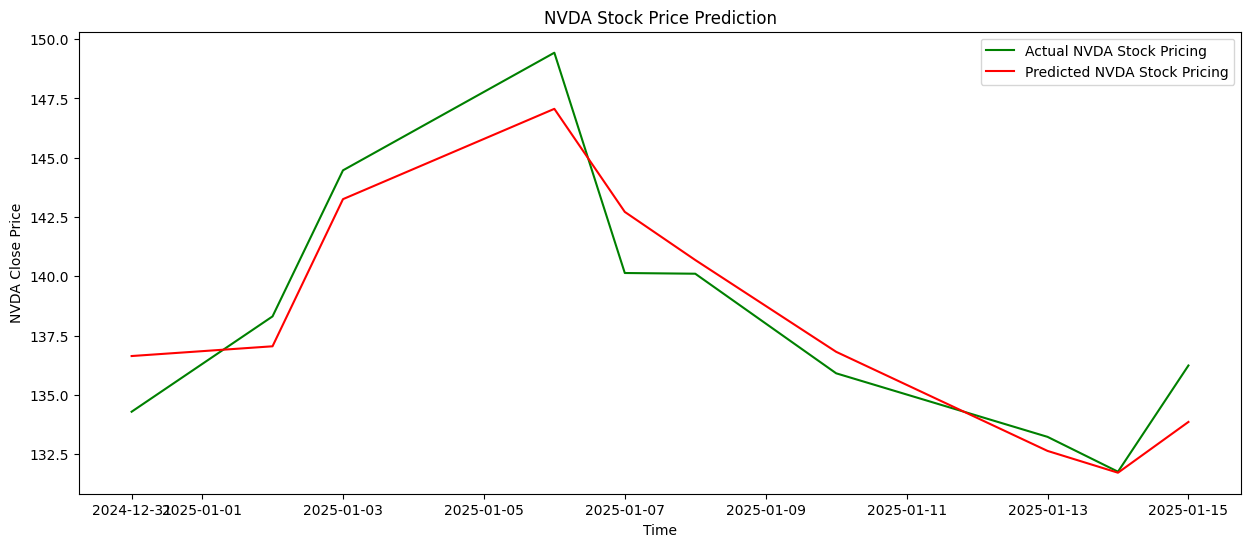

In [34]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(raw_df[len(raw_df)-len(y_test):].index, y_test, color="green", label="Actual NVDA Stock Pricing")
axes.plot(raw_df[len(raw_df)-len(y_test):].index, y_test_pred, color="red", label="Predicted NVDA Stock Pricing")

plt.title("NVDA Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("NVDA Close Price")
plt.legend()
plt.show()


## 6. Fetch and filter latest history of stock

Let's have the model predict the upcoming Close values for NVIDIA from the last time it opened.

In [35]:
recent_nvda_df = nvda.history(period="1d") # ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

In [36]:
recent_nvda_df.isnull().values.any()
recent_nvda_df = recent_nvda_df.drop(columns=["Dividends", "Stock Splits"])

recent_features = recent_nvda_df.drop("Close", axis=1)
recent_label_df = recent_nvda_df.pop("Close")
recent_label_df = recent_label_df.rename("Close")

In [37]:
norm_df = feature_standardizer.transform(recent_features)
newdf = pd.DataFrame(norm_df, index=recent_features.index, columns=recent_features.columns)

In [38]:
newdf.head() # only one row to represent one day

,Open,High,Low,Volume
Date,,,,
2025-01-15 00:00:00-05:00,-1.226987,-1.127103,-1.229381,-0.550218


In [39]:
recent_label_df.head() # this is what the close value should be

Date
2025-01-15 00:00:00-05:00    136.240005
Name: Close, dtype: float64

In [40]:
recent_features, recent_label = torch.tensor(newdf.values, dtype=torch.float, device=device), torch.tensor(recent_label_df.values, dtype=torch.float, device=device)
# this is if you want to teach how to move it to gpu
# recent_features = recent_features.to(device)
# recent_label = recent_label.to(device)

In [41]:
print(f"recent_features: {recent_features.device}, recent_label: {recent_label.device}")

recent_features: cuda:0, recent_label: cuda:0


## 7. Predict recent Close value with AI and compare it to the real Close Value

In [42]:
model.eval()
with torch.inference_mode():
    prediction = model(recent_features)

In [43]:
prediction_df = pd.DataFrame(data=prediction.cpu(), columns=["Close"])
norm_prediction = label_standardizer.inverse_transform(prediction_df) # format: [[NUMBER]], access via norm_prediction[0][0]
print(norm_prediction)

[[133.85944]]


In [44]:
recent_label_df

Date
2025-01-15 00:00:00-05:00    136.240005
Name: Close, dtype: float64

In [45]:
real_close_value = recent_label_df.iloc[0] # first value of Series
predicted_close_value = norm_prediction[0][0]

print(f"Predicted Close Value: ${predicted_close_value:.2f}, Actual Close Value: ${real_close_value:.2f}")

Predicted Close Value: $133.86, Actual Close Value: $136.24
